In [1]:
import numpy as np
import pandas as pd
from DS_models_stat import do_all_stats, cut_cat
from astropy.coordinates import SkyCoord
from astropy import units as u
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

In [2]:
df41 = pd.read_csv('/home/rt2122/Data/SRGz/brcat.csv')
df41 = cut_cat(df41, big_pix=[41]) 

In [3]:
mp_q = np.array(df41['max_pred'].quantile(np.arange(0.0, 1.05, 0.05)))
mp_q

array([ 5.001107  ,  5.0574152 ,  5.1187033 ,  5.1852174 ,  5.263441  ,
        5.3243025 ,  5.3988073 ,  5.47482965,  5.576395  ,  5.6695565 ,
        5.7931575 ,  5.9338782 ,  6.0500642 ,  6.23831895,  6.4377301 ,
        6.71012225,  7.0996798 ,  7.53313595,  8.1812544 , 10.131869  ,
       59.07298   ])

In [4]:
true_cats = {'PSZ2(z)' : '/home/rt2122/Data/clusters/planck_z.csv',
             'PSZ2' : '/home/rt2122/Data/original_catalogs/csv/PSZ2.csv',
            'MCXC' : '/home/rt2122/Data/original_catalogs/csv/MCXC.csv',
            'ACT' : '/home/rt2122/Data/original_catalogs/csv/ACT.csv',
            'Abell' : '/home/rt2122/Data/original_catalogs/csv/Abell.csv',
            'eROSITA' : '/home/rt2122/Data/SRGz/clusters/clusters1_east_val_edit.csv'}
true_cats = {key : pd.read_csv(true_cats[key]) for key in true_cats}

big_pix = [41]
true_cats = {key : cut_cat(true_cats[key], big_pix = big_pix) for key in true_cats}
true_cats_sc = {key : SkyCoord(ra=np.array(true_cats[key]['RA']) * u.degree, 
                               dec=np.array(true_cats[key]['DEC']) * u.degree, frame='icrs') for key in true_cats}

In [5]:
prec41 = []
for st, en in tqdm(zip(mp_q[:-1], mp_q[1:])):
    cur_df = df41[df41['max_pred'] >= st]
    cur_df.index = np.arange(len(cur_df))
    
    stats = do_all_stats(cur_df, true_cats, true_cats_sc=true_cats_sc, match_dist=400/3600)
    prec41.append(stats['precision'])

/home/rt2122/L/git/data-segmentation-2/modules/DS_models_stat.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  det_cat['found'] = False
/home/rt2122/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


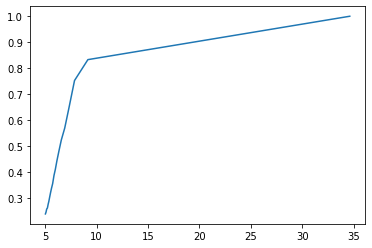

In [6]:
plt.plot((mp_q[:-1] + mp_q[1:])/2, prec41)

In [7]:
mp_q[0] = 4
mp_q[-1] = 88
mp_q

array([ 4.        ,  5.0574152 ,  5.1187033 ,  5.1852174 ,  5.263441  ,
        5.3243025 ,  5.3988073 ,  5.47482965,  5.576395  ,  5.6695565 ,
        5.7931575 ,  5.9338782 ,  6.0500642 ,  6.23831895,  6.4377301 ,
        6.71012225,  7.0996798 ,  7.53313595,  8.1812544 , 10.131869  ,
       88.        ])

In [8]:
prec41.append(1.0)

In [9]:
def find_prec(st, en, prec1, prec2, cur_mp):
    
    def find_kb(coords1, coords2):
        #y1 = kx1 + b
        #y2 = kx2 + b
        #y1- y2 = k(x1 - x2)
        #k = (y1-y2)/(x1-x2)
        #b=y1-kx1
        k = coords1[1] - coords2[1]
        k /= coords1[0] - coords2[0]
        b = coords1[1] - k * coords1[0]
        return k, b
    
    k, b = find_kb([st, prec1], [en, prec2])
    if st <= cur_mp and cur_mp <= en:
        return k * cur_mp + b
    else:
        return -1

In [10]:
df = pd.read_csv('/home/rt2122/Data/SRGz/brcat.csv')
df = df.sort_values(by='max_pred', axis='index', ascending=True)
df['mpp'] = 0
df.index = np.arange(len(df))
df.head(4)

,RA,DEC,max_pred,galmask,psmask,CO_mask,mpp
0,65.909328,15.799634,5.000039,0,1,0,0
1,146.452715,-10.044695,5.000144,1,0,1,0
2,99.635969,-51.502430,5.000328,1,1,1,0
3,271.903476,60.487588,5.000338,1,1,1,0


In [11]:
i = 0
st = mp_q[i]
en = mp_q[i + 1]
prec1 = prec41[i]
prec2 = prec41[i + 1]
for j in tqdm(range(len(df))):
    line = df.iloc[j]
    mp = line['max_pred']
    if mp > en:
        i += 1
        st = mp_q[i]
        if i + 1 >= len(mp_q):
            en = 1
        else:
            en = mp_q[i + 1]
        prec1 = prec41[i]
        prec2 = prec41[i + 1]
    prec_val = find_prec(st, en, prec1, prec2, mp)
    if prec_val < 0 or not (prec1 <=prec_val and prec_val <= prec2):
        break
    df.loc[j, 'mpp'] = prec_val

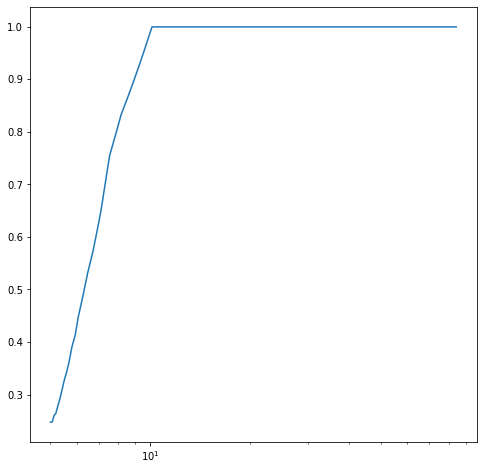

In [14]:
_, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.set_xscale('log')
ax.plot(df['max_pred'], df['mpp'])

In [13]:
df

,RA,DEC,max_pred,galmask,psmask,CO_mask,mpp
0,65.909328,15.799634,5.000039,0,1,0,0.247193
1,146.452715,-10.044695,5.000144,1,0,1,0.247194
2,99.635969,-51.502430,5.000328,1,1,1,0.247195
3,271.903476,60.487588,5.000338,1,1,1,0.247195
4,175.415688,39.959376,5.000418,1,1,1,0.247196
...,...,...,...,...,...,...,...
13767,84.837042,-70.110884,65.094880,0,0,0,1.000000
13768,79.776578,-5.889819,66.187060,0,0,0,1.000000
13769,83.552657,-6.557328,66.651710,0,0,0,1.000000
13770,82.754616,-5.248693,70.113630,0,0,0,1.000000


In [15]:
df.to_csv('/home/rt2122/Data/SRGz/brcat_mpp.csv', index=False)